# Symphony
Oct 9, 2020

In this example, we will construct a reference from two pbmc datasets (3'V1 and 3'V2), then map a third (5') with Symphony.

In [5]:
remove.packages('symphony')

Removing package from ‘/PHShome/jbk37/anaconda3/envs/env_r3.6/lib/R/library’
(as ‘lib’ is unspecified)


ERROR: Error in find.package(pkgs, lib): there is no package called ‘symphony’


In [6]:
devtools::install_github("immunogenomics/symphony")


✔  checking for file ‘/tmp/RtmpyVzUR2/remotes254062e38001/immunogenomics-symphony-888fab1/DESCRIPTION’
─  preparing ‘symphony’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘symphony_1.0.tar.gz’
   


In [7]:
library(symphony)

In [8]:
# for analysis
library(dplyr)
library(singlecellmethods)
library(harmony)
library(irlba)

# for figures
library(ggrastr)
library(ggpubr)
library(ggplot2)
library(ggthemes)

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: data.table

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last


Attaching package: ‘singlecellmethods’

The following object is masked from ‘package:base’:

    rowMeans

Loading required package: Rcpp
Loading required package: Matrix
Loading required package: ggplot2


## Get the data

In [9]:
datapath = '/data/srlab/jkang/rotation/PBMC10X_partners/'

# Read in normalized expression and metadata
exprs_norm = readRDS(paste(datapath, 'exprs_norm_all.rds', sep = ''))
metadata = read.csv(paste(datapath, 'meta_data_subtypes.csv', sep = ''))

dim(exprs_norm)
dim(metadata)

[1] 33694 20886

[1] 20886     8

In [10]:
#rename the datasets
metadata$donor = recode(metadata$donor, fivePrime = "5'", threepfresh = "3'V2", threepv1 = "3'V1")

In [11]:
head(metadata)

cell_id,donor,nUMI,nGene,percent_mito,cell_type,res_0.80,cell_subtype
<fct>,<fct>,<int>,<int>,<dbl>,<fct>,<int>,<fct>
threepfresh_AAACCTGAGCATCATC,3'V2,2394,871,0.03842941,bcells,3,bnaive
threepfresh_AAACCTGAGCTAACTC,3'V2,1694,806,0.05726092,mono,5,mono14
threepfresh_AAACCTGAGCTAGTGG,3'V2,4520,1316,0.01946903,tcells,2,cd4mem
threepfresh_AAACCTGCACATTAGC,3'V2,2788,898,0.01398852,tcells,1,cd4naive
threepfresh_AAACCTGCACTGTTAG,3'V2,4667,1526,0.03621170,mono,0,mono14
threepfresh_AAACCTGCATAGTAAG,3'V2,4440,1495,0.03806306,mono,0,mono14


## Subset into reference and query

In [12]:
idx_query = which(metadata$donor == "5'")
ref_exp = exprs_norm[, -idx_query]
ref_metadata = metadata[-idx_query, ]
query_exp = exprs_norm[, idx_query]
query_metadata = metadata[idx_query, ]

# Build Symphony Reference

## Option 1: Build from scratch (starting with expression)

In [14]:
# Build reference
reference = symphony::buildReference(
    ref_exp,
    ref_metadata,
    vars = c('donor'),  # variables to integrate over
    K = 100,            # number of Harmony clusters
    verbose = TRUE,
    do_umap = TRUE,     # can set to FALSE if want to run umap separately later
    do_normalize = FALSE, # set to TRUE if input counts are not normalized yet.
    vargenes_method = 'vst', # use vst
    topn = 2000,             # number of variable genes to use
    d = 20,                  # number of PCs
    save_uwot_path = '/data/srlab/jkang/referencemapping/201009_testing_uwot_model_1'
)

# Save reference
saveRDS(reference, '/data/srlab/jkang/referencemapping/201009_testing_reference.rds')

Finding variable genes
Scaling and PCA
start Harmony
Harmony 1/20
Harmony 2/20
Harmony 3/20
Harmony 4/20
Harmony 5/20
Harmony 6/20
Harmony 7/20
Harmony 8/20
Harmony 9/20
Harmony 10/20
Harmony 11/20
Harmony 12/20
Harmony converged after 12 iterations
UMAP
Warning message:
“invalid uid value replaced by that for user 'nobody'”Saved uwot model


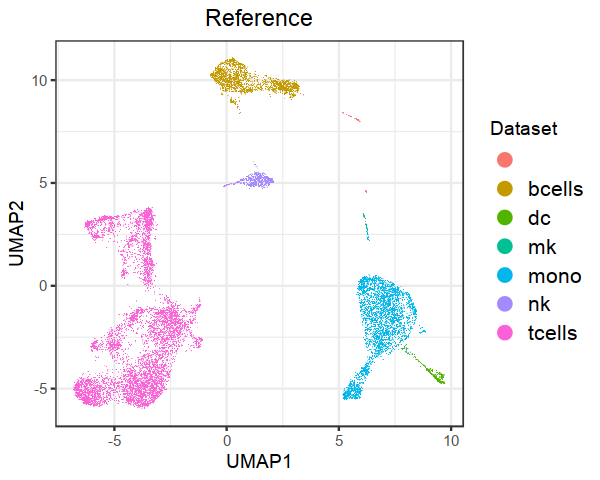

In [38]:
# Visualize reference UMAP
reference = readRDS('/data/srlab/jkang/referencemapping/201009_testing_reference.rds')

colnames(reference$umap$embedding) = c('UMAP1', 'UMAP2')
umap_labels = cbind(ref_metadata, reference$umap$embedding)

fig.size(4, 5)
p1 = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_type)) +
    geom_point_rast(size = 0.4, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Reference', color = 'Dataset') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    #scale_color_manual(values=c("#f5ba25", "#1c77d9", "#11ba3a")) +
    theme(legend.position="right") +
    theme(legend.text = element_text(size=12)) + 
    guides(colour = guide_legend(override.aes = list(size = 4)))
p1

## Option 2: Build from Harmony object
This is helpful if you want your code to be more modular.

In [16]:
# Subset by variable genes
var_genes = vargenes_vst(ref_exp, topn = 2000)
ref_exp <- ref_exp[var_genes, ]

In [17]:
vargenes_means_sds <- tibble(symbol = var_genes, mean = Matrix::rowMeans(ref_exp))
vargenes_means_sds$stddev <- singlecellmethods::rowSDs(ref_exp, vargenes_means_sds$mean)
        
# Scale data
ref_exp_scaled <- singlecellmethods::scaleDataWithStats(ref_exp, vargenes_means_sds$mean, 
                                                        vargenes_means_sds$stddev, 1)

In [18]:
head(vargenes_means_sds)

symbol,mean,stddev
<chr>,<dbl>,<dbl>
RPL39,3.139277,1.695006
LYZ,1.796387,1.907826
S100A9,1.609852,1.849555
S100A8,1.381827,1.777127
HLA-DRA,1.904308,1.708515
CD74,2.555970,1.536484


In [19]:
# Run SVD, save loadings
s = irlba(ref_exp_scaled, nv = 20)
Z_pca_ref = diag(s$d) %*% t(s$v) # [pcs by cells]
loadings = s$u

In [20]:
# Run Harmony to harmonize the reference
ref_harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca_ref), ## PCA embedding matrix of cells
        meta_data = ref_metadata, ## dataframe with cell labels
        theta = c(2), ## cluster diversity enforcement
        vars_use = c('donor'), ## variable to integrate out
        nclust = 100, ## number of clusters in Harmony model
        max.iter.harmony = 10,
        return_object = TRUE, ## return the full Harmony model object
        do_pca = FALSE ## don't recompute PCs
)

Harmony 1/10
Harmony 2/10
Harmony 3/10
Harmony 4/10
Harmony 5/10
Harmony 6/10
Harmony 7/10
Harmony 8/10
Harmony 9/10
Harmony 10/10


To run the next function `buildReferenceFromHarmonyObj`, you need the saved gene loadings and vargenes_means_sds.

In [21]:
# Compress Harmony reference into a Symphony reference
reference = symphony::buildReferenceFromHarmonyObj(
                           ref_harmObj, #output object from HarmonyMatrix()
                           ref_metadata,
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs
                           verbose = TRUE, 
                           do_umap = TRUE,         # run reference umap?
                           save_uwot_path = '/data/srlab/jkang/referencemapping/201009_testing_uwot_model_2')

Save metadata, vargenes (S), and loadings (U)
Save R, Z_orig, Z_corr, and betas from Harmony object
Calculate final L2 normalized reference centroids (Y_cos)
Calculate reference compression terms (Nr and C)
UMAP
Warning message:
“invalid uid value replaced by that for user 'nobody'”Saved uwot model
Finished nicely.


In [29]:
# Save reference
saveRDS(reference, '/data/srlab/jkang/referencemapping/201009_testing_reference2.rds')

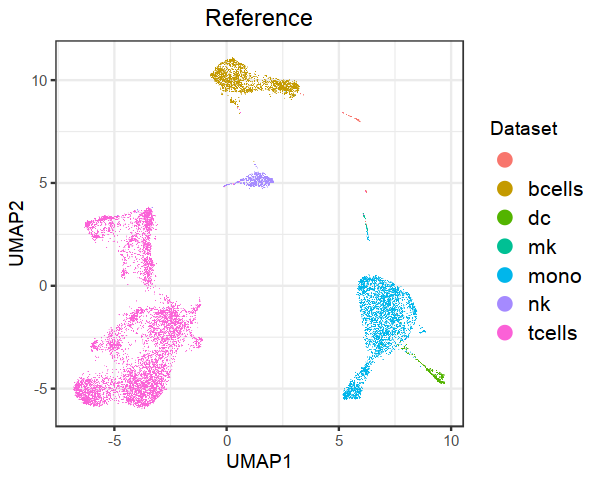

In [39]:
# Visualize reference UMAP
reference = readRDS('/data/srlab/jkang/referencemapping/201009_testing_reference2.rds')

colnames(reference$umap$embedding) = c('UMAP1', 'UMAP2')
umap_labels = cbind(ref_metadata, reference$umap$embedding)

fig.size(4, 5)
p1 = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_type)) +
    geom_point_rast(size = 0.4, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Reference', color = 'Dataset') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    #scale_color_manual(values=c("#f5ba25", "#1c77d9", "#11ba3a")) +
    theme(legend.position="right") +
    theme(legend.text = element_text(size=12)) + 
    guides(colour = guide_legend(override.aes = list(size = 4)))
p1

# Map query

In [31]:
reference = readRDS('/data/srlab/jkang/referencemapping/201009_testing_reference.rds')

In [32]:
# Map query
query = mapQuery(query_exp, query_metadata, reference, do_normalize = FALSE)

# Predict query cell types using knn
query = knnPredict(query, reference, reference$meta_data$cell_type, k = 5)

Scaling and synchronizing query gene expression
Project
Cluster
Correct
UMAP
All done!


In [33]:
head(query$meta_data)

,cell_id,donor,nUMI,nGene,percent_mito,cell_type,res_0.80,cell_subtype,cell_type_pred_knn
,<fct>,<fct>,<int>,<int>,<dbl>,<fct>,<int>,<fct>,<fct>
13190,fivePrime_AAACCTGAGCGATAGC,5',2712,1318,0.06637168,nk,9,nk,nk
13191,fivePrime_AAACCTGAGCTAAACA,5',6561,2164,0.05654626,mono,0,mono14,mono
13192,fivePrime_AAACCTGAGGGAGTAA,5',6322,2112,0.05615312,mono,0,mono14,mono
13193,fivePrime_AAACCTGAGTCTTGCA,5',4528,1526,0.07199647,tcells,11,cd8eff,tcells
13194,fivePrime_AAACCTGAGTTCGATC,5',3426,1332,0.06830123,mono,0,mono14,mono
13195,fivePrime_AAACCTGCACACTGCG,5',6199,1998,0.05097596,bcells,8,bmem,bcells


In [34]:
# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA

reference$meta_data$ref_query = 'reference'
query$meta_data$ref_query = 'query'

meta_data_combined = rbind(query$meta_data, reference$meta_data)

# Add the UMAP coordinates to the metadata
colnames(reference$umap$embedding) = c('UMAP1', 'UMAP2')
colnames(query$umap) = c('UMAP1', 'UMAP2')
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

# Plot query cells on top
umap_combined_labels = umap_combined_labels[order(-as.numeric(factor(umap_combined_labels$ref_query))),]

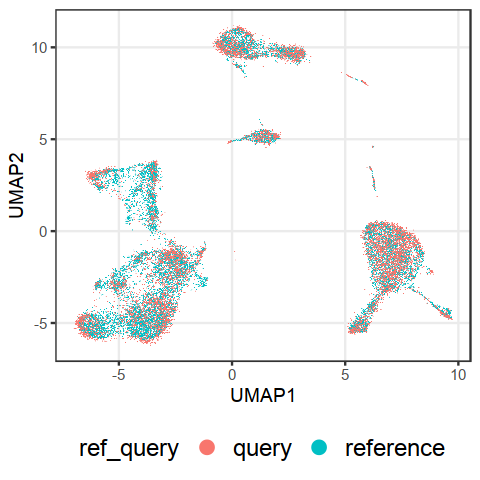

In [41]:
# Plot UMAP visualization
fig.size(4, 4)

q = umap_combined_labels %>%
    ggplot(aes(x = UMAP1, y = UMAP2, col = ref_query)) +
    geom_point_rast(size = 0.4, stroke = 0.2, shape = 16) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="bottom") +
    theme(legend.text = element_text(size=14), plot.title = element_text(size=16), 
          legend.title=element_text(size=14)) + 
    guides(colour = guide_legend(override.aes = list(size = 4))) +
    scale_x_continuous(minor_breaks = seq(-10, 10, 5)) +
    scale_y_continuous(minor_breaks = seq(-10, 10, 5))
q